# Predicción de insuficiencia cardíaca

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de todas las muertes en todo el mundo. Los factores de riesgo conductuales más importantes de las enfermedades cardiacas y los accidentes cerebrovasculares son la dieta malsana, la inactividad física, el consumo de tabaco y el consumo nocivo de alcohol. Los efectos de los factores de riesgo conductuales pueden manifestarse en las personas en forma de hipertensión, hiperglucemia e hiperlipidemia, además de sobrepeso y obesidad. 

La insuficiencia cardíaca es un evento común causado por ECV y este conjunto de datos contiene 12 características que pueden usarse para predecir la mortalidad por insuficiencia cardíaca.

Las personas con enfermedades cardiovasculares o que tienen un alto riesgo cardiovascular (por la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan una detección y manejo temprano en el que un modelo de aprendizaje automático puede ser de gran ayuda.

In [1]:
# importar librerías

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm 
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
import multiprocessing

In [3]:
# cargando los datos 

data = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Descripción de las variables

* `age`: edad del paciente,

* `anaemia`: sí el paciente presenta niveles bajos de hemoglobina (*variable booleana*),

* `creatinine_phosphokinase`: nivel de la enzima *CPK* en la sangre (*mcg/L*),

* `diabetes`: si el paciente tiene *diabete* (*variable booleana*),

* `ejection_fraction`: porcentaje de sangre que sale del corazón en cada contracción,

* `high_blood_pressure`: Si el paciente tiene hipertensión (*variable booleana*),

* `platelets`: conteo de plaquetas en la sangre (*kiloplaqueta/mL*),

* `serum_creatinine`: nivel de creatinina sérica en la sangre (*mg/dL*)

* `serum_sodium`: nivel de sodio sérico en la sangre (*mEq/L*)

* `sex`: sexo del paciente,

* `smoking`: si el paciente fuma o no (*variable booleana*),

* `time`: período de seguimiento al paciente (*días*)

* `DEATH_EVENT`: si el paciente falleció durante el período de seguimiento.

## Preprocesamiento y análisis de los datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**Nota:**

* No parecen haber datos perdidos,

* Todas las variables parecen tener el tipo adecuado.

[Text(0, 0, '203'), Text(0, 0, '96')]

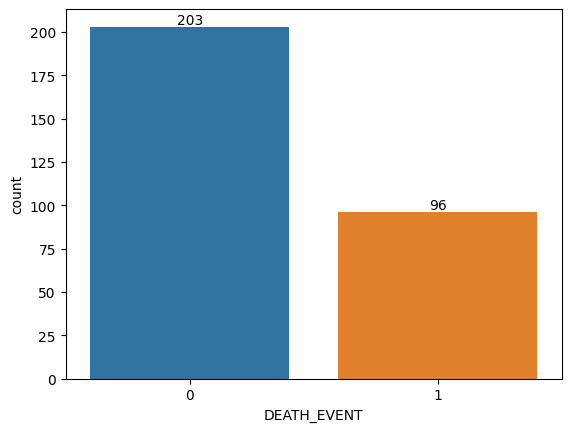

In [5]:
ax = sns.countplot(x= data["DEATH_EVENT"])
ax.bar_label(ax.containers[0])

**Nota:**

Existe un desbalance de clases en la variable objetivo: **las personas que mueren son menos de la mitad que las personas que sobreviven**. 

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


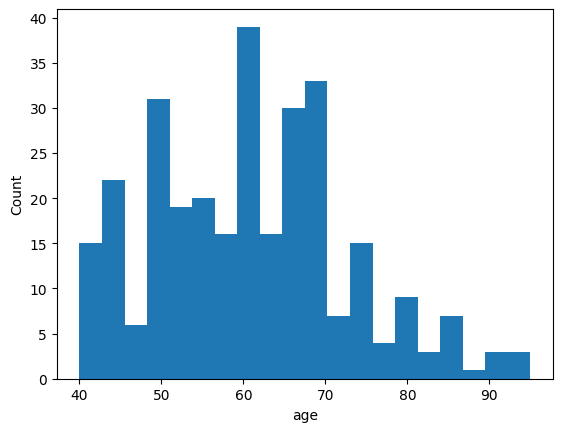

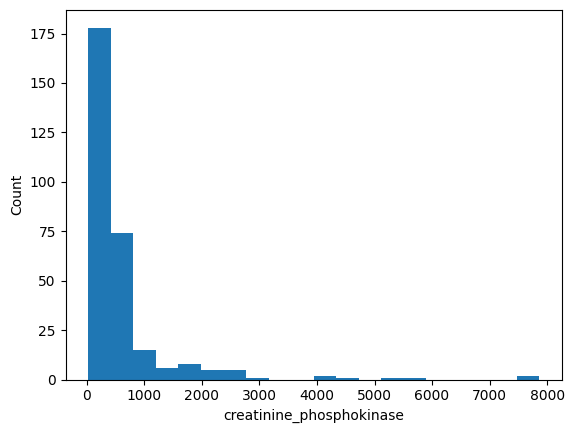

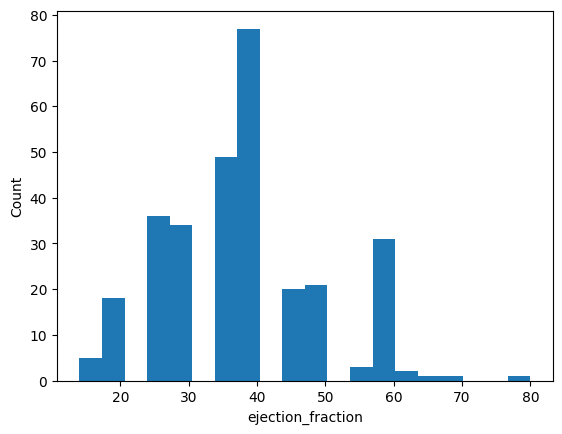

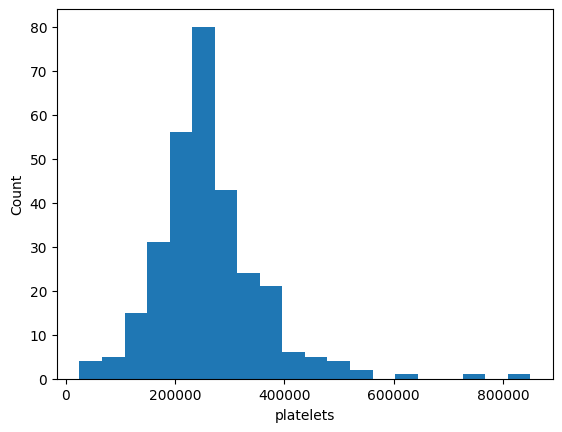

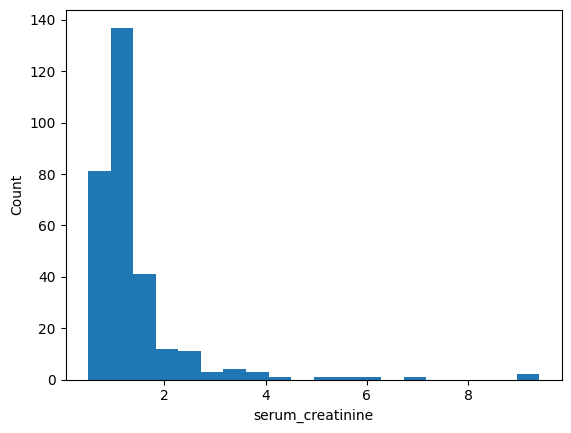

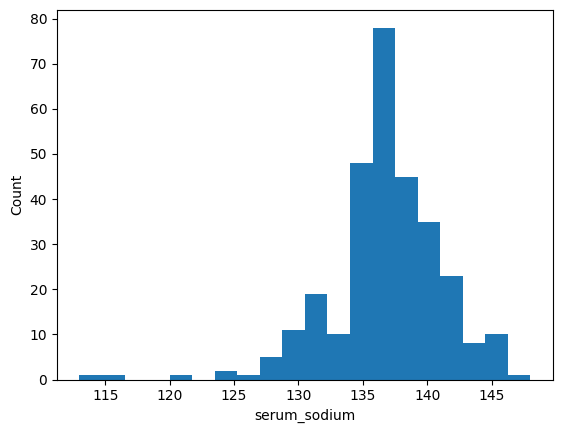

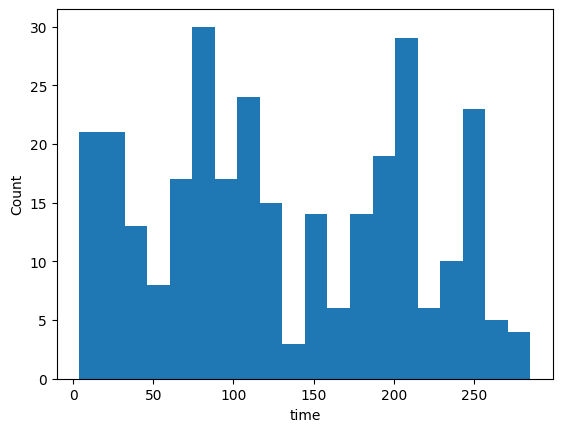

In [7]:
columns_nums = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium',
                'time']

for col in columns_nums:             
  plt.hist(x = data[col], bins = 20)
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.show()

**Nota:**

* La variable `age` parece tener un ligero sezgo a la derecha: los pacientes entre **40 y 70 años** parecen ser los más frecuentes.

* La variable `creatinine_phosphokinase` parece tener un fuerte sezgo a la izquierda, valores pequeños por **debajo de 600** son más frecuentes.

* La variable `serum_creatinine` también tiene un sezgo hacia la izquierda.

* La variable `time` parece estar más o menos distribuida uniformemente. 

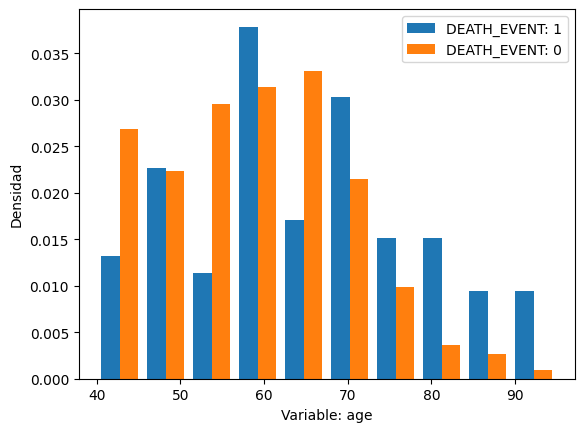

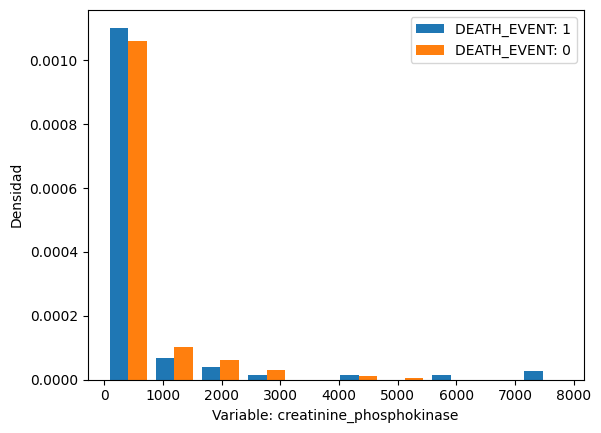

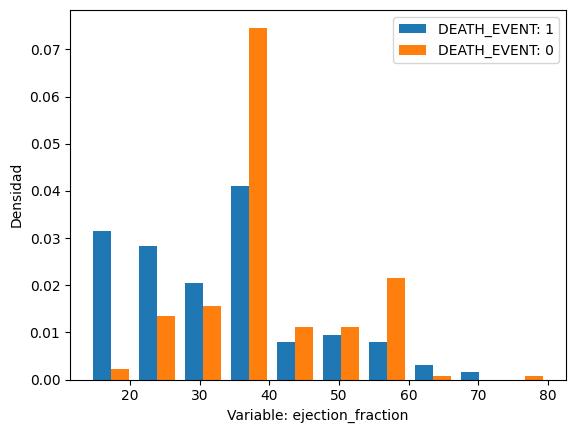

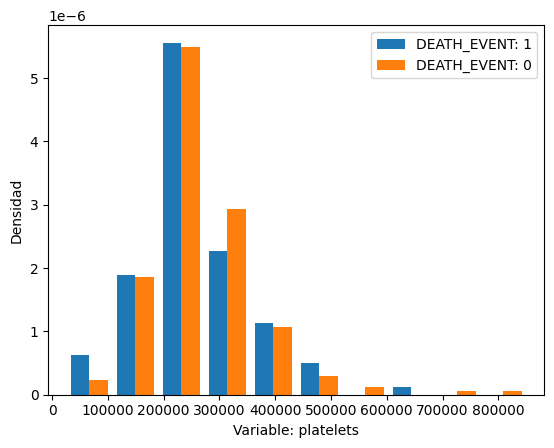

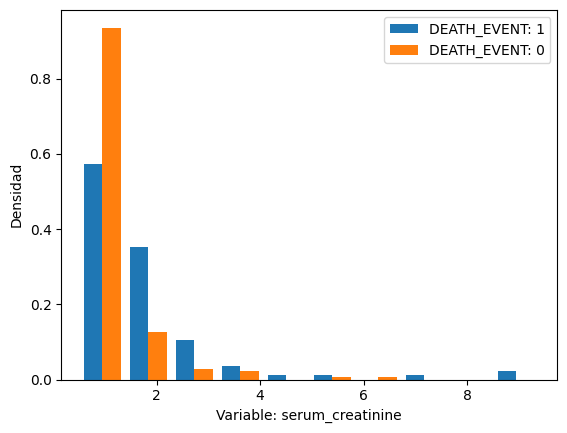

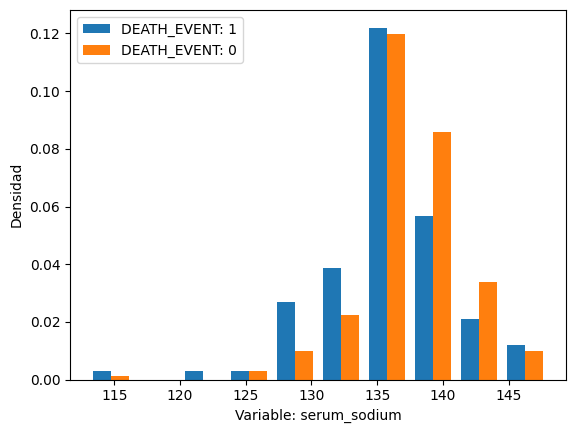

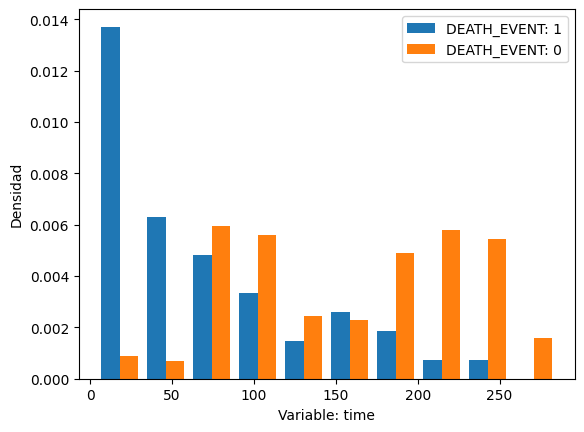

In [8]:
for col in columns_nums:
  data_dead = data[data['DEATH_EVENT'] == 1][col]
  data_no_dead = data[data['DEATH_EVENT'] == 0][col]
  x = [data_dead, data_no_dead]
  plt.hist(x, density = True)
  plt.xlabel(f'Variable: {col}')
  plt.ylabel('Densidad')
  plt.legend(['DEATH_EVENT: 1', 'DEATH_EVENT: 0'])
  plt.show()

**Nota:**

* Cuando dibujamos los histogramas por clase de la variable `DEATH_EVENT` se observan cambios interesantes en la distribución de algunas de las variables numéricas.

* En el grupo de personas que murieron, son más frecuentes las personas **mayores de 70 años**, con fracciones de ejección **menores de 30 porciento**, y con períodos de control **menores de 75 días**. Es decir, las variables `age`, `ejection_fraction` y `time` evidentemente están influyendo en si la persona muere o no. 

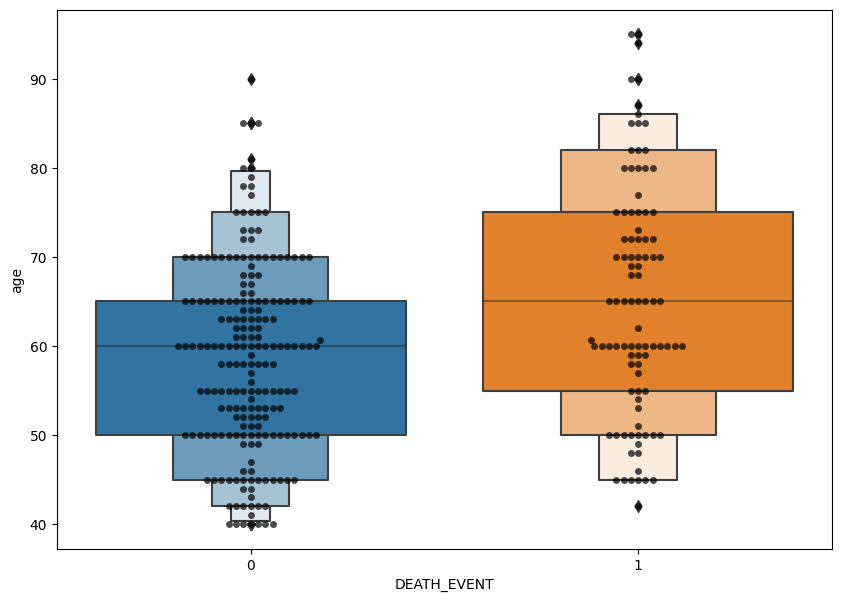

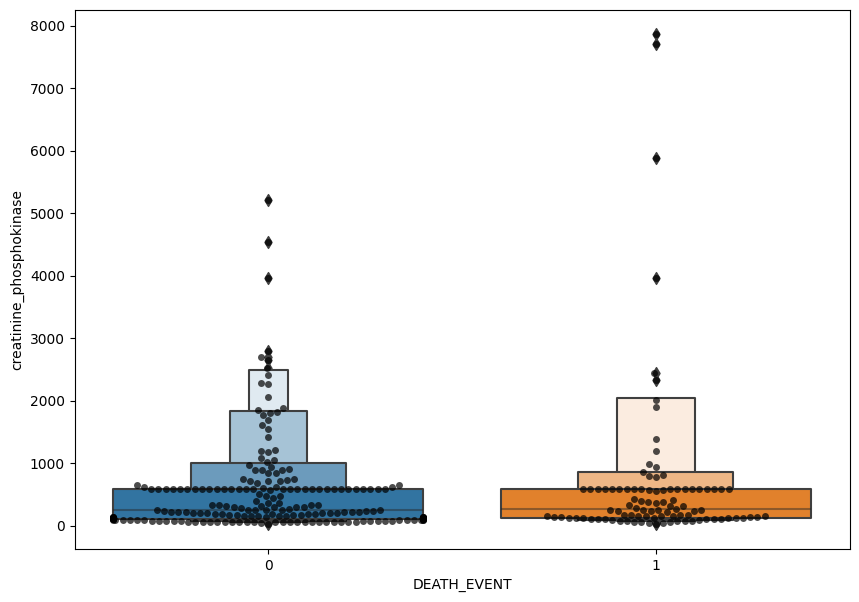

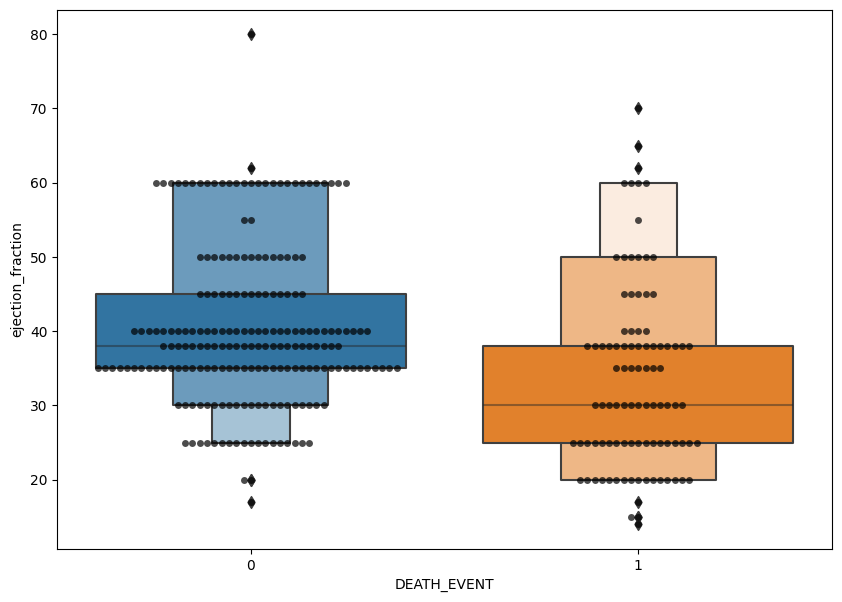

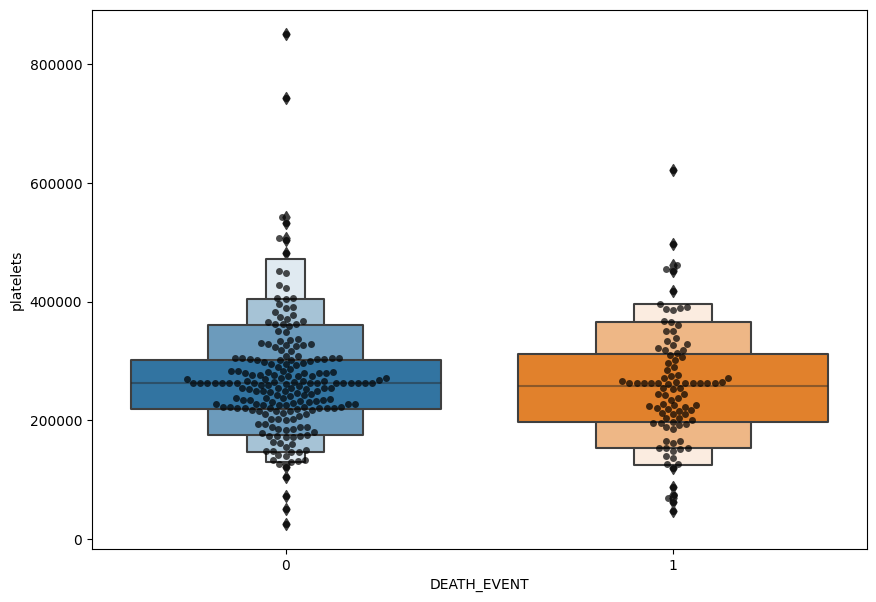

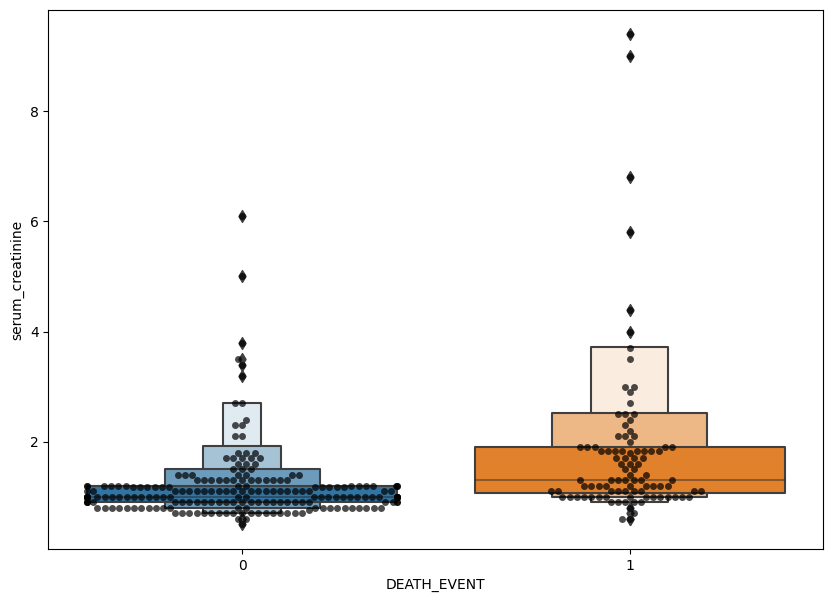

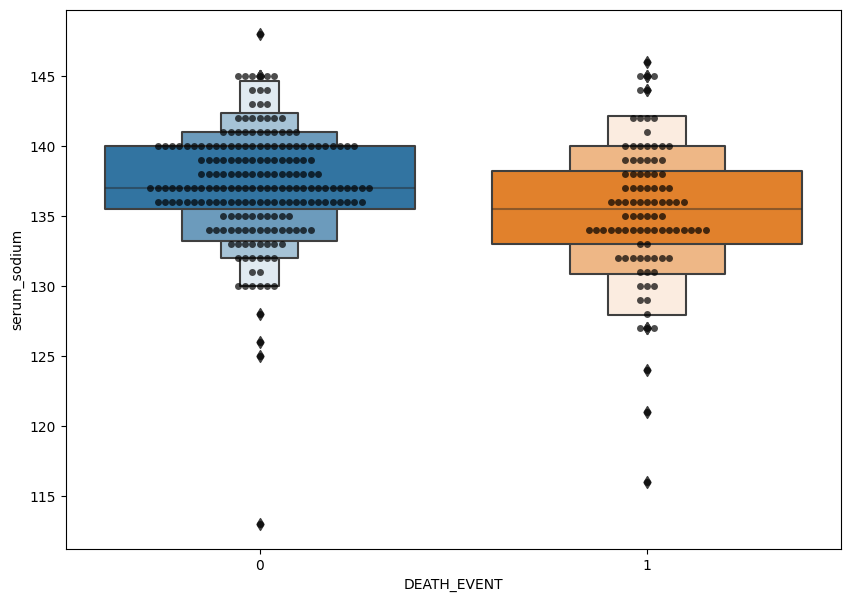

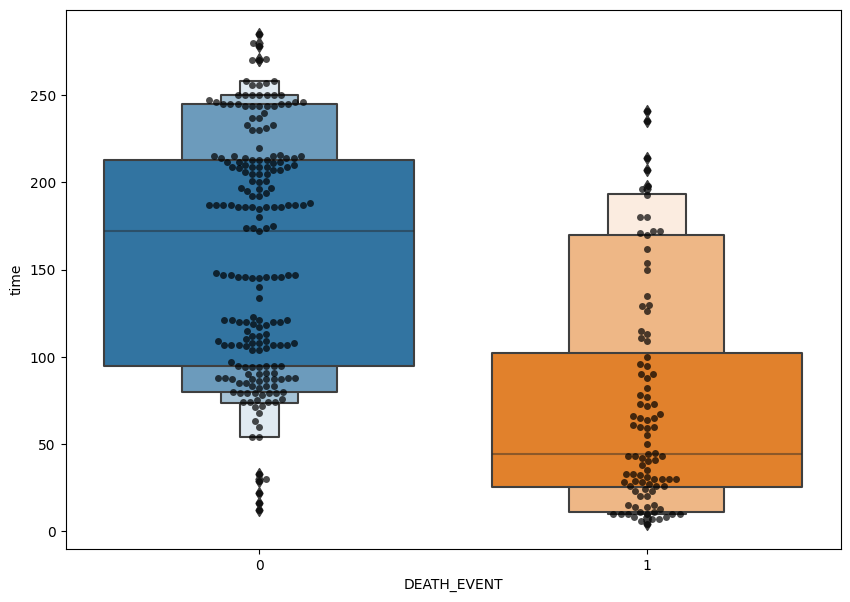

In [9]:
for col in columns_nums: 
    plt.figure(figsize=(10,7))
    sns.swarmplot(x=data["DEATH_EVENT"], y=data[col], color="black", alpha=0.7)
    sns.boxenplot(x=data["DEATH_EVENT"], y=data[col])
    plt.show() 

**Nota:**

Hay *outliers* en casi todas las variables, sin embargo, son pocos. Decidimos no eliminar los *outlaiers* teniendo en cuenta que tenemos muy pocas observaciones.

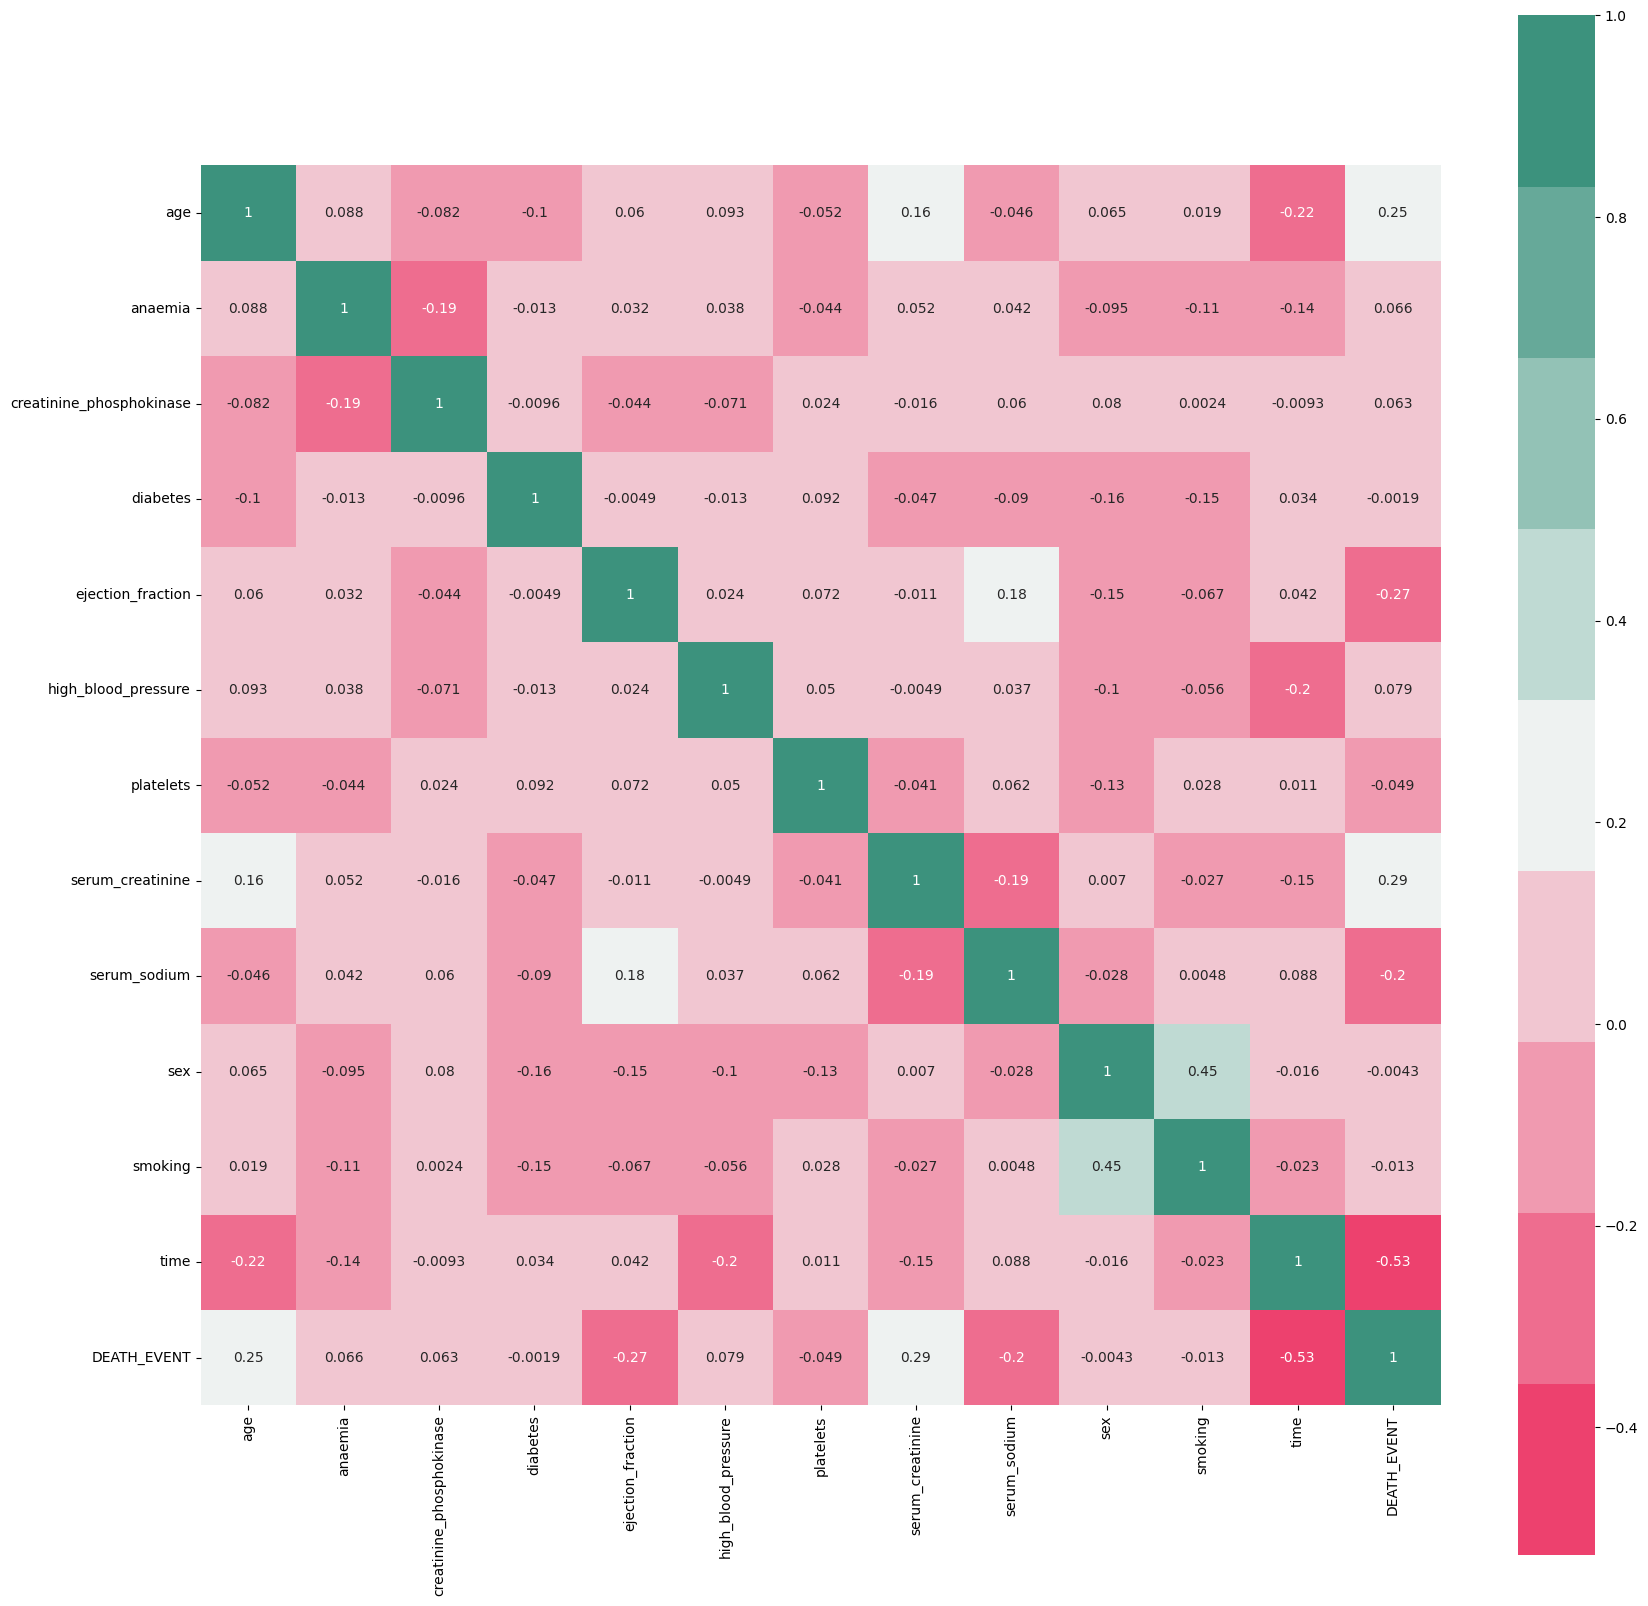

In [10]:
cmap = sns.diverging_palette(2, 165, s=80, l=55, n=9)
corrmat = data.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)
plt.show()

**Nota:**

La `edad` y el `tiempo` de en el que la persona ha estado en observación son las variables más correlacionadas con el evento de muerte.

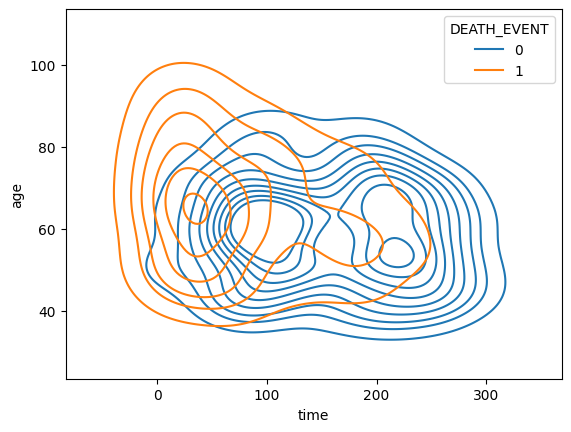

In [11]:
sns.kdeplot(x=data["time"], y=data["age"], hue =data["DEATH_EVENT"])
plt.show()

**Nota:**

* En el grupo de pacientes que mueren, se observa mayor dispersión en la edad y más concentración en la región donde el período de seguimiento es menor de 50 días. 

* El grupo de pacientes que sobreviven hay más dispersión en la edad y en el período de seguimiento. 

# Evaluando los modelos de clasificación

## Preparando los datos

In [12]:
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

In [13]:
s_scaler = preprocessing.StandardScaler()
X_scaled= s_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)   
X_scaled.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879


In [14]:
X_train, X_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.30,random_state=25)

## Random Forest Classifier 

In [15]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini']
             }

grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'criterion': ['gini'], 'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [16]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 50} : 0.8372822299651569 accuracy


In [17]:
modelo_rf_final = grid.best_estimator_
pred_train = modelo_rf_final.predict(X_train)
acc_train = accuracy_score(y_train, pred_train)

pred_test = modelo_rf_final.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)

print('El accuracy de entrenamiento es:', acc_train)
print('El accuracy de prueba es:', acc_test)

El accuracy de entrenamiento es: 0.8995215311004785
El accuracy de prueba es: 0.8555555555555555


In [18]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90        60
           1       0.84      0.70      0.76        30

    accuracy                           0.86        90
   macro avg       0.85      0.82      0.83        90
weighted avg       0.85      0.86      0.85        90



## Red neuronal artificial

In [19]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 25, epochs = 80,callbacks=[early_stopping], validation_split=0.25)

Epoch 1/80
7/7 [==============================] - 2s 50ms/step - loss: 0.6928 - accuracy: 0.6154 - val_loss: 0.6907 - val_accuracy: 0.8302
Epoch 2/80
7/7 [==============================] - 0s 11ms/step - loss: 0.6918 - accuracy: 0.6346 - val_loss: 0.6882 - val_accuracy: 0.8302
Epoch 3/80
7/7 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.6346 - val_loss: 0.6858 - val_accuracy: 0.8302
Epoch 4/80
7/7 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.6346 - val_loss: 0.6835 - val_accuracy: 0.8302
Epoch 5/80
7/7 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.6346 - val_loss: 0.6809 - val_accuracy: 0.8302
Epoch 6/80
7/7 [==============================] - 0s 11ms/step - loss: 0.6876 - accuracy: 0.6346 - val_loss: 0.6784 - val_accuracy: 0.8302
Epoch 7/80
7/7 [==============================] - 0s 10ms/step - loss: 0.6868 - accuracy: 0.6346 - val_loss: 0.6750 - val_accuracy: 0.8302
Epoch 8/80
7/7 [============

In [20]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 86.30%


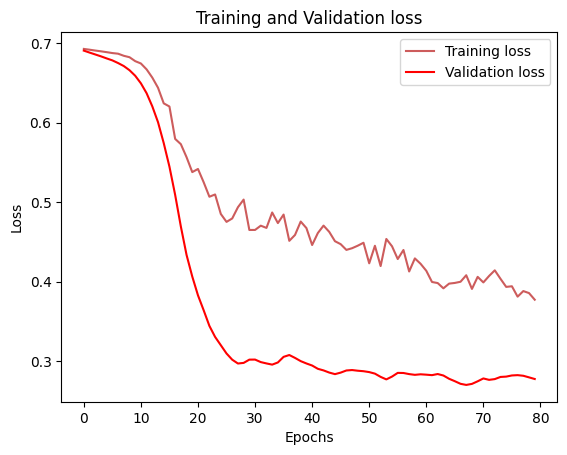

In [21]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

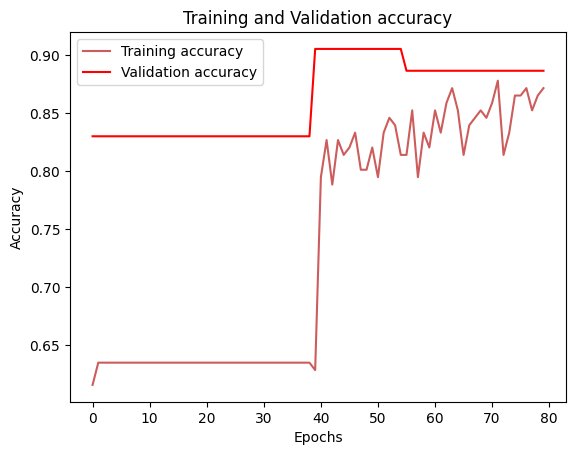

In [22]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.4)
np.set_printoptions()

3/3 [==============================] - 0s 5ms/step


In [35]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83        60
           1       0.65      0.73      0.69        30

    accuracy                           0.78        90
   macro avg       0.75      0.77      0.76        90
weighted avg       0.79      0.78      0.78        90



# Conclusiones

Hemos entrenado dos modelos para predecir el riesgo de muerte en una persona que bajo determinadas condiciones pueden medirse 12 variables relacionadas directa e indirectamente con el funcionamiento del corazón. Estos dos modelos son: `RandomForest` y una `Red Neuronal completamente conectada` (MLP). La primera, parece tener mejor rendimiento en cuanto a las métricas que hemos mostrado. 

**Nota:** 

En este estudio es importante tener en cuenta el origen de los datos. En este caso, estos fueron tomados a pacientes internados en el Instituto de Cardiología y en el Hospital Allied de Faisalabad-Pakistan de abril a diciembre de 2015. Todos los pacientes son mayores de 40 años y presentan una disfunción sistólica del ventrículo izquierdo. Es decir, este es un modelo entrenado con datos tomados en circusntancias muy particulares a pacientes con una condición grave. Esto demuestra que el uso y la utilidad de los modelos dependen de las características de los datos. 